# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

The only way to get started is to get started - so let's grab our dependencies for the day!

> NOTE: Using this notebook as presented will incur a charge of ~$3USD from OpenAI usage.

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Creating a Simple RAG Pipeline with LangChain v.0.2.0
  4. Task 4: Synthetic Dataset Generation for Evaluation using Ragas (Optional)

- 🤝 Breakout Room #2
  1. Task 1: Evaluating our Pipeline with Ragas
  2. Task 2: Testing OpenAI's Claim
  3. Task 3: Selecting an Advanced Retriever and Evaluating

> NOTE: This Notebook *does* contain a bonus challenge, outlined at the bottom of the notebook, which you can complete instead of the notebook for full marks on the assignment.

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://python.langchain.com/v0.2/docs/versions/v0_2/) of LangChain v0.2.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [1]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai langchain-qdrant

We'll also get the "star of the show" today, which is Ragas!

In [2]:
!pip install -qU ragas

We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [3]:
!pip install -qU qdrant-client pymupdf pandas

## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [4]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.2.0

Building on what we've been learning, we'll be leveraging LangChain v0.2.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

- [`PyMuPDFLoader`](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.2.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader

PDF_LINK = "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"

loader = PyMuPDFLoader(
    file_path=PDF_LINK,
)

documents = loader.load()

In [10]:
documents[0].metadata

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'page': 0,
 'total_pages': 195,
 'format': 'PDF 1.3',
 'title': 'The Pmarca Blog Archives',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': 'Mac OS X 10.10 Quartz PDFContext',
 'creationDate': "D:20150110020418Z00'00'",
 'modDate': "D:20150110020418Z00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

- [`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain-text-splitters-character-recursivecharactertextsplitter)

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 200
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [12]:
len(documents)

1864

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

- [`OpenAIEmbeddings`](https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain-openai-embeddings-base-openaiembeddings)

> NOTE: We are purposefully using an older embedding model to try and answer the guiding question: Is TE3 better than Ada-002?

In [13]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-ada-002"

embeddings = OpenAIEmbeddings(
    model=EMBEDDING_MODEL
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

- [`Qdrant`](https://api.python.langchain.com/en/latest/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore)

> NOTE: You'll need to provide the embedding dimension for Ada-002!

In [14]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

LOCATION = ":memory:"
COLLECTION_NAME = "PMarca Blogs"
VECTOR_SIZE = 1536

In [16]:
qdrant_client = QdrantClient(location=LOCATION)

qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client = qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings
)

qdrant_vector_store.add_documents(documents)

['a633db278fa04124af807aaa1c7e2265',
 'e613974217464fa18ff58d5f7f88b93a',
 'f7b083090f9a4a54b6e55ca972f59256',
 'b8ab5edee17747aeb5febcfc7573a370',
 '2761b1c064304f218c0e8e1a44acc5d4',
 '87c15ccd251c487aa704ee93342b77bf',
 'fdd9040895ce47de97686cf3cd019a2f',
 'c277b884319948738ced202bc2399b94',
 '4ea3e388ee144d5f9e5fa0eb668c1169',
 'de5c18bbf01d42c98443929839036a87',
 '75006e8b141a419db32be9d1f6e3678d',
 '8370ca291c2b4835b893089c8c5f5c21',
 '275ddca7d0024a8db3dc6325d8c28c04',
 '5310089d62a64d9dbe6ab2df55c36b98',
 '0ea1fc492b5f4f90b72954c7fbe50d18',
 'ff6082ea415b4037a6e31ee8a133afcf',
 '26441ebe1ba9420db7f444bca84cb457',
 '8d9f5b52ffa542b18135e46382be91b3',
 '7de7b4e169fa4c5d8b25d2f592839243',
 '494533906af04bf5a99881bcee11b89d',
 'c356cf60a36e42a785d2a11b88dc497f',
 'e4648d6f3252429bb6d0f7ab399f0905',
 'e0551f73aa3e4e248b7cd328518c6ea1',
 '0f026e3734d240079f4b836e63494a19',
 'a8e61653ffa94e4eb70dea01a438d2ff',
 '5f9193458f694740961c276a11113660',
 'ec2dbb8028994ca4a4e65ac27681b759',
 

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about QDrant!

Qdrant employs below techniques to enhance its performance:

- Hierarchical Navigable Small World (HNSW): A graph-based algorithm for fast Approximate Nearest Neighbor (ANN) search.
- Product Quantization: Helps compress and efficiently store high-dimensional vectors.
- In-Memory or Memmap Storage: Options for high-speed vector storage either in RAM or via memory-mapped files.
- Optimized Distance Metrics: Supports Euclidean, Cosine, and Dot Product similarity for various search tasks.

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [17]:
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [18]:
retrieved_documents = retriever.invoke("What is a rule of thumb for selecting an industry to invest in?")

In [19]:
for doc in retrieved_documents:
  print(doc)

page_content='the existing order — and make sure that those forces of change
have a reasonable chance at succeeding.
Second rule of thumb:
Once you have picked an industry, get right to the center of it' metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '7e1a1c2065724285a3f2bb68f0cd609d', '_collection_name': 'PMarca Blogs'}
page_content='Third rule:
In a rapidly changing Held like technology, the best place to
get experience when you’re starting out is in younger, high-
growth companies.' metadata={'source': 'https://d1lamhf6l6yk6d.cloud

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [20]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

/opt/miniconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/opt/miniconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/client.py:5519: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [21]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [22]:
from langchain.prompts import ChatPromptTemplate

template = """
You are a helpful AI assistant that can answer questions based on the context. If out of context, respont with "I'm sorry, I can't answer that question."

Question:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [23]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

Let's test it out!

In [24]:
question = "What is a rule of thumb for selecting an industry to invest in?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

A rule of thumb for selecting an industry to invest in is to identify the existing order and ensure that the forces of change within that industry have a reasonable chance of succeeding. Additionally, once you have picked an industry, it's advisable to get right to the center of it, where the great opportunities can be found.


In [25]:
question = "What did Pink Floyd have to say about how to proceed when investing in a new industry?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

I'm sorry, I can't answer that question.
[Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 15, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '47ca0c5da2fc45dabf862e1036fa1cb2', '_collection_name': 'PMarca Blogs'}, page_content='ask if you can call them again if things change.\nTrust me — they’d much rather be saying “yes” than “no” —\nthey need all the good investments they can get.\nSecond, consider the environment.'), Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfro

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

## Task 4: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

In [26]:
loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

- It ensures diversity in the dataset,
- Improves model generalization - learns the underlying pattern from the context 
- Captures various contexts
- Increasing its ability to understand relationships and nuances in the data

In [27]:
len(eval_documents)

624

> NOTE: 🛑 Running this cell as presented will incur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step. **YOU CAN SKIP THIS STEP BY LOADING THE `.csv` DIRECTLY FROM OUR REPOSITORY.** 🛑

#### Optional: SDG for Evaluation

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 20 # You can reduce the number of QA pairs to 5 if you're experiencing rate-limiting issues

testset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)
testset.to_pandas()

Let's look at the output and see what we can learn about it!

In [ ]:
testset.test_data[0]

In [ ]:
testset_df = testset.to_pandas()
testset_df.to_csv("testset.csv")

#### PREFERRED: Download `.csv` from DataRepository

In [ ]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

In [25]:
!mv DataRepository/testset.csv .

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [28]:
import pandas as pd

test_df = pd.read_csv("testset.csv")

In [29]:
test_df

,Unnamed: 0,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,0,How does the tendency to avoid inconsistency c...,['Five: Inconsistency-Avoidance Tendency\n[Peo...,The tendency to avoid inconsistency contribute...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,1,What are some of the challenges faced by start...,['structure that any established company has.\...,"In a startup, it is easy for the code not to g...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,2,What factors should be considered when decidin...,['Part 2: Skills and education\n[Please read m...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,3,What should be valued when evaluating candidat...,"[""How to hire the best people you've\never wor...",The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,4,What are the consequences of not raising enoug...,['Here’s why you shouldn’t do that:\nWhat are ...,Not raising enough money risks the survival of...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,5,How does Structured Procrastination suggest us...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,6,What analogy is used to describe the layers of...,['as if it’s an onion. Just like you peel an o...,The analogy used to describe the layers of ris...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,7,How can Structured Procrastination be used to ...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,8,How is the quality of a startup's product defi...,['Let’s start by deXning terms.\nThe caliber o...,The quality of a startup's product in the tech...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,9,What role can a campus computer lab play in he...,"['undergrads to do some of the work, and being...",A campus computer lab can play a role in helpi...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


In [30]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [31]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [32]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [33]:
response_dataset[0]

{'question': 'How does the tendency to avoid inconsistency contribute to people being reluctant to change?',
 'answer': "The tendency to avoid inconsistency contributes to people's reluctance to change because change represents a form of inconsistency. People often cling to their previous conclusions, loyalties, reputational identity, and commitments, which are maintained by the brain's anti-change tendency. This makes it difficult for individuals to embrace new ideas or identities, as they may feel that doing so would create a conflict with their established beliefs and behaviors. As a result, they may resist change until they are ready to accept new ideas or until a new generation emerges that is more open to change.",
 'contexts': ['Five: Inconsistency-Avoidance Tendency\n[People are] reluctant to change, which is a form of inconsistency\navoidance. We see this in all human habits, constructive and',
  'less brain-blocked by its previous conclusions…\nOne corollary of Inconsistency-

# 🤝 Breakout Room Part #2

## Task 1: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [34]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [35]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Exception raised in Job[13]: TimeoutError()


In [36]:
results

{'faithfulness': 0.7339, 'answer_relevancy': 0.9271, 'context_recall': 0.6360, 'context_precision': 0.7469, 'answer_correctness': 0.5799}

In [37]:
results_df = results.to_pandas()
results_df

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,How does the tendency to avoid inconsistency c...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The tendency to avoid inconsistency contribute...,The tendency to avoid inconsistency contribute...,0.933333,0.957898,0.500000,0.805556,0.458554
1,What are some of the challenges faced by start...,[ied and determined. Sales calls get made. The...,Some of the challenges faced by startups in es...,"In a startup, it is easy for the code not to g...",0.875000,0.991209,1.000000,1.000000,0.550764
2,What factors should be considered when decidin...,[including your formal education. So I will st...,"When deciding what to study in college, some f...",The answer to given question is not present in...,0.631579,0.993568,1.000000,NaN,0.177030
3,What should be valued when evaluating candidat...,[priate for your particular startup.\nWith a w...,"When evaluating candidates for a startup, it i...",The answer to given question is not present in...,0.800000,0.967892,1.000000,0.000000,0.179921
4,What are the consequences of not raising enoug...,[Here’s why you shouldn’t do that:\nWhat are t...,Not raising enough money risks the survival of...,Not raising enough money risks the survival of...,1.000000,0.991354,0.333333,0.833333,0.572774
5,How does Structured Procrastination suggest us...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination suggests that inste...,Structured Procrastination suggests that inste...,1.000000,0.960308,1.000000,0.916667,0.782251
6,What analogy is used to describe the layers of...,[as if it’s an onion. Just like you peel an on...,The analogy used to describe the layers of ris...,The analogy used to describe the layers of ris...,1.000000,1.000000,1.000000,0.750000,0.891534
7,How can Structured Procrastination be used to ...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination can be used to one'...,Structured Procrastination suggests that inste...,1.000000,0.987979,0.500000,0.805556,0.991689
8,How is the quality of a startup's product defi...,[The quality of a startup’s pr\nproduct\noduct...,The quality of a startup's product in the tech...,The quality of a startup's product in the tech...,1.000000,0.993645,0.000000,1.000000,0.651019
9,What role can a campus computer lab play in he...,[What should I do while I’m in school?\nI’m a ...,A campus computer lab can play a significant r...,A campus computer lab can play a role in helpi...,0.500000,0.979579,0.333333,0.750000,0.876638


## Task : Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #1:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

### Response
We are using "text-embedding-3-small" model for the first to define a baseline. Then later we use the new model to see the difference in the output.

In [38]:
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### Response
Create a Qdrant based vector store that uses the `text-embedding-3-small` model for converting the documents into vectors. Here we are using 1536 dimension and using Cosine similarity search.

In [41]:
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"TE3NEW",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"TE3NEW",
    embedding=te3_embeddings,
)

qdrant_vector_store.add_documents(documents)

['5a9430abfc64401f8ac30667667f1fe1',
 '0e2429d748464841b7d3e3239cc6833e',
 '5d04884732584d3daa6779e8808eab2b',
 '01646b220cb945c2bf0490122c4bd416',
 '6308c4e0e38f47409f931fd9cbbf20e2',
 '96fc1ed5ee61420d8fd43f4cf9b5cf54',
 '542d7db18cda4d4b87fefebe323b0acf',
 '1b58bb9da99248cdaedee434f6d89fa9',
 'fbb4b16c945c409dba69a3f70ca95ca5',
 '201939318fd04c118f40b9fc394a3d13',
 '7f33b7f1c7ae41229140ce5e0126a016',
 'c9d2dbc5d3d1480fbd39ba04e5b25010',
 '7bf01e5b0b174da6ba03d314461214bf',
 '05a21a5a7e804650b13af2e285727ab9',
 'e80299d248314d0297660f73a4a666cc',
 'c784ebcbd38e48218dff1594b6e20233',
 '503e89f9dd5f4a169628de9fb8d4fd63',
 'ff71d304461a4d9a9d6dc7ec15fdc6bf',
 'a2f1594e1a59422785661438c58eebdb',
 '69596df7de3c44278765dadb111a959c',
 'dcd79788effc4cb28703b1b8cc1f525d',
 '3d2b6ca0310e46d0a8e507bf69925f97',
 'ab682e12ba994f9882a750bbab37cd98',
 '8ac87ac99fbc4daf8c2aa8ef86c4dbea',
 '99b77ef35360455595c40212cd3dad0b',
 'f738cf4019cb46f38b8289da64b96d5c',
 '6254e7618d4149a1a2eaa492957ff228',
 

In [42]:
te3_retriever = qdrant_vector_store.as_retriever()

In [43]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

In [44]:
from langchain.chains import create_retrieval_chain

te3_retrieval_chain = create_retrieval_chain(te3_retriever, document_chain)

In [45]:
answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [46]:
te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [47]:
te3_ad.vanced_retrieval_results = evaluate(te3_response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [48]:
te3_advanced_retrieval_results

{'faithfulness': 0.7752, 'answer_relevancy': 0.9722, 'context_recall': 0.6228, 'context_precision': 0.6155, 'answer_correctness': 0.6464}

In [49]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])

df_merged = pd.merge(df_baseline, df_comparison, on='Metric')

df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']

df_merged

,Metric,ADA,TE3,Baseline -> TE3
0,faithfulness,0.733938,0.775213,0.041276
1,answer_relevancy,0.927105,0.972159,0.045054
2,context_recall,0.635965,0.622807,-0.013158
3,context_precision,0.746914,0.615497,-0.131417
4,answer_correctness,0.579930,0.646439,0.066509


####❓ Question #3:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

### Response

Newer models like  `text-embedding-3-small` are optimized for performance, potentially offering better speed, efficiency, and embedding quality for certain tasks. Times the improvement may not be significat for all the tasks.
Newer models supports more dimension which in turn provides more context and retrieval is performant. But in this case both these model support 1536 dimensions and we may not see a significat changes in the results. 
From the above result we can see the `context_precision` has gone down from ada to te3 model. 

## Task 5: Selecting an Advanced Retriever and Evaluating

#### 🏗️ Activity #2

While the changes that occured due to modifying the embedding model were desirable - you're now tasked with improving `context_recall`, or `context_precision` (or both!).

You'll follow these steps:

1. Reason about this list of Advanced Retrieval methods:
  - [Contextual Compression (Reranker)](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/)
  instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned. “Compressing” here refers to both compressing the contents of an individual document and filtering out documents wholesale.
  - [MultiQueryRetriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/)
    automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query.  For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents. 
  - [Parent Document Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/parent_document_retriever/)
    The ParentDocumentRetriever strikes that balance by splitting and storing small chunks of data. During retrieval, it first fetches the small chunks but then looks up the parent ids for those chunks and returns those larger documents.
1. Select the method you think will be the most performant.
2. Implement that method.
3. Create a LCEL chain that utlizes the new Retriever method.
4. Evaluate this LCEL and compare to the TE3 results.

> NOTE: We will spend more time in Session 14 diving into advanced retrieval methods, this activity is only to serve as a basic introduction to the idea of component-wise improvements and how they might impact metrics.

### Contextual Compression

In [51]:
# We are going to use the same embedding model `text-embedding-3-small` for the retrieval chain
# but with advanced retrieval techniques `Contextual Compression`
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# Base retriever
te3_retriever = qdrant_vector_store.as_retriever()
base_retriever = te3_retriever

#Create a contextual compressor
compressor_llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=4000)
compressor = LLMChainExtractor.from_llm(compressor_llm)

#Combine the retriever with the compressor
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=base_retriever
)

# Create chain 
document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)
te3_retrieval_chain_compressed = create_retrieval_chain(te3_retriever, document_chain)


In [52]:

answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain_compressed.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

te3_response_dataset_compressed_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

te3_advanced_retrieval_compressed_results = evaluate(te3_response_dataset_compressed_retrieval, metrics)


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [54]:
df_compressed = pd.DataFrame(list(te3_advanced_retrieval_compressed_results.items()), columns=['Metric', 'TE3 Compressed'])

df_merged = pd.merge(df_merged, df_compressed,on='Metric')

df_merged['TE3 -> TE3Compressed'] = df_merged['TE3 Compressed'] - df_merged['TE3']
df_merged

,Metric,ADA,TE3,Baseline -> TE3,TE3 Compressed,TE3 -> TE3Compressed
0,faithfulness,0.733938,0.775213,0.041276,0.782576,0.007362
1,answer_relevancy,0.927105,0.972159,0.045054,0.973002,0.000843
2,context_recall,0.635965,0.622807,-0.013158,0.622807,0.000000
3,context_precision,0.746914,0.615497,-0.131417,0.615497,0.000000
4,answer_correctness,0.579930,0.646439,0.066509,0.630734,-0.015704


### Multi Query Retriver

In [55]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_llm = ChatOpenAI(temperature=0)
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=te3_retriever, llm=multi_query_llm
)

# Create chain to generate answers for the test sets
document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)
te3_retrieval_chain_multiquery = create_retrieval_chain(te3_retriever, document_chain)

In [56]:

answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain_multiquery.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

te3_response_dataset_multiquery_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

te3_advanced_retrieval_multiquery_results = evaluate(te3_response_dataset_multiquery_retrieval, metrics)


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Exception raised in Job[84]: TimeoutError()
Exception raised in Job[70]: TimeoutError()


In [62]:
df_multiquery = pd.DataFrame(list(te3_advanced_retrieval_multiquery_results.items()), columns=['Metric', 'TE3 MultiQuery'])

df_merged = pd.merge(df_merged, df_multiquery,on='Metric')

df_merged['TE3Compressed -> TE3MultiQuery'] = df_merged['TE3 MultiQuery'] - df_merged['TE3 Compressed']
# df_merged = df_merged.drop('TE3 MultiQuery_x', axis=1)
# df_merged = df_merged.drop('TE3 MultiQuery', axis=1)
# df_merged = df_merged.drop('TE3 MultiQuery_y', axis=1)
# df_merged = df_merged.drop('TE3 TE3Compressed -> TE3MultiQuery', axis=1)
df_merged


,Metric,ADA,TE3,Baseline -> TE3,TE3 Compressed,TE3 -> TE3Compressed,TE3Compressed -> TE3MultiQuery,TE3 MultiQuery
0,faithfulness,0.733938,0.775213,0.041276,0.782576,0.007362,0.014480,0.797056
1,answer_relevancy,0.927105,0.972159,0.045054,0.973002,0.000843,-0.002458,0.970544
2,context_recall,0.635965,0.622807,-0.013158,0.622807,0.000000,0.000000,0.622807
3,context_precision,0.746914,0.615497,-0.131417,0.615497,0.000000,0.013158,0.628655
4,answer_correctness,0.579930,0.646439,0.066509,0.630734,-0.015704,0.049363,0.680097


In [ ]:
# Ignore this cell 
import displayresult
from IPython.display import HTML

df_with_arrows = displayresult.highlight_improvement(df_merged[['Metric', 'ADA', 'TE3', 'TE3 Compressed', 'TE3 MultiQuery']])
HTML(df_with_arrows.to_html(escape=False, index=False))

### Parent Document Retriever

In [80]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

# This text splitter is used to create the child documents
child_splitter = text_splitter # RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=50)

te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

LOCATION = ":memory:"
COLLECTION_NAME = "PMarca Blogs TE3ParentDoc"
VECTOR_SIZE = 1536
qdrant_client_parentdoc = QdrantClient(location=LOCATION)
qdrant_client_parentdoc.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

qdrant_vector_store_parentdoc = QdrantVectorStore(
    client=qdrant_client_parentdoc,
    collection_name=COLLECTION_NAME,
    embedding=te3_embeddings,
)

# The storage layer for the parent documents
store = InMemoryStore()
parent_doc_retriever = ParentDocumentRetriever(
    vectorstore=qdrant_vector_store_parentdoc,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)
PDF_LINK = "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"
loader = PyMuPDFLoader(
    file_path=PDF_LINK,
)

parent_doc_retriever.add_documents(loader.load(), ids=None)

In [81]:
# Create chain to generate answers for the test sets
document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)
te3_retrieval_chain_parentdoc = create_retrieval_chain(parent_doc_retriever, document_chain)

In [82]:

answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain_parentdoc.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

te3_response_dataset_parentdoc_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

te3_advanced_retrieval_parentdoc_results = evaluate(te3_response_dataset_parentdoc_retrieval, metrics)


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [96]:
df_parentdoc = pd.DataFrame(list(te3_advanced_retrieval_parentdoc_results.items()), columns=['Metric', 'TE3 ParentDoc'])

df_merged = pd.merge(df_merged, df_parentdoc,on='Metric')

df_merged['TE3MultiQuery -> TE3ParentDoc'] = df_merged['TE3 ParentDoc'] - df_merged['TE3 MultiQuery']

# df_merged = df_merged.drop('TE3 ParentDoc', axis=1)
# df_merged = df_merged.drop('TE3MultiQuery -> TE3ParentDoc', axis=1)
df_merged


,Metric,ADA,TE3,Baseline -> TE3,TE3 Compressed,TE3 -> TE3Compressed,TE3Compressed -> TE3MultiQuery,TE3 MultiQuery,TE3 ParentDoc,TE3MultiQuery -> TE3ParentDoc
0,faithfulness,0.733938,0.775213,0.041276,0.782576,0.007362,0.014480,0.797056,0.859717,0.062661
1,answer_relevancy,0.927105,0.972159,0.045054,0.973002,0.000843,-0.002458,0.970544,0.918410,-0.052134
2,context_recall,0.635965,0.622807,-0.013158,0.622807,0.000000,0.000000,0.622807,0.807018,0.184211
3,context_precision,0.746914,0.615497,-0.131417,0.615497,0.000000,0.013158,0.628655,0.767544,0.138889
4,answer_correctness,0.579930,0.646439,0.066509,0.630734,-0.015704,0.049363,0.680097,0.584446,-0.095652


In [ ]:
# Ignore this cell
import displayresult
from IPython.display import HTML

df_with_arrows = displayresult.highlight_improvement(df_merged[['Metric', 'ADA', 'TE3', 'TE3 Compressed', 'TE3 MultiQuery', 'TE3 ParentDoc']])
HTML(df_with_arrows.to_html(escape=False, index=False))

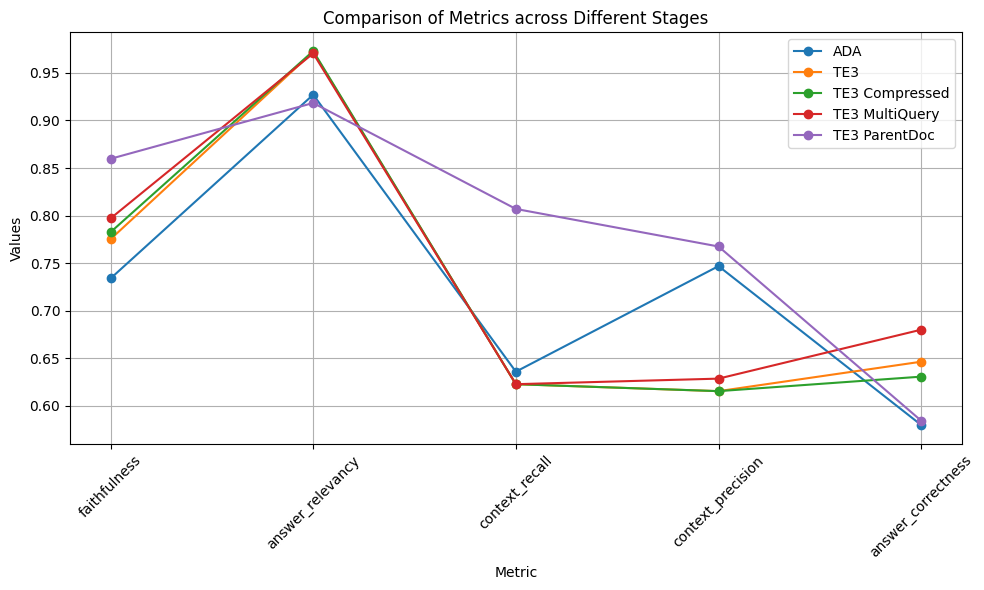

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10,6))
for col in df_merged.columns[1:]:  # Exclude the 'Metric' column
    if '->' not in col:
        plt.plot(df_merged['Metric'], df_merged[col], marker='o', label=col)

plt.title("Comparison of Metrics across Different Stages")
plt.xlabel("Metric")
plt.ylabel("Values")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🚧 BONUS CHALLENGE 🚧

> NOTE: Completing this challenge will provide full marks on the assignment, regardless of the complete of the notebook. You do not need to complete this in the notebook for full marks.

##### **MINIMUM REQUIREMENTS**:

1. Baseline `LCEL RAG` Application using `NAIVE RETRIEVAL`
2. Baseline Evaluation using `RAGAS METRICS`
  - [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
  - [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
  - [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
  - [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
  - [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)
3. Implement a `SEMANTIC CHUNKING STRATEGY`.
4. Create an `LCEL RAG` Application using `SEMANTIC CHUNKING` with `NAIVE RETRIEVAL`.
5. Compare and contrast results.

##### **SEMANTIC CHUNKING REQUIREMENTS**:

Chunk semantically similar (based on designed threshold) sentences, and then paragraphs, greedily, up to a maximum chunk size. Minimum chunk size is a single sentence.

Have fun!